# Explore correlation of genes
This notebook performs a first pass exploration of the data. In particular, this notebook examines the types of interactions that exist between genes and how coordinated groups of genes are: core-core, core-accessory, accessory-accessory 

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy as sc

np.random.seed(123)

/home/alexandra/anaconda3/envs/core-acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User - which experiments to use
which_experiments = "All"

In [3]:
# Input
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

real_expression_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "input",
    "selected_"+which_experiments+"_data.tsv")

shuffled_expression_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "input",
    "shuffled_"+which_experiments+"_selected_data.tsv")

gene_annot_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "annotations",
    "selected_gene_annotations.txt")

In [4]:
# Output directory to store gene ids and correlation outputs
base_intermediate_dir = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "tmp")

In [5]:
# Read data
real_expression = pd.read_csv(
    real_expression_file,
    header=0,
    sep='\t',
    index_col=0)

shuffled_expression = pd.read_csv(
    shuffled_expression_file,
    header=0,
    sep='\t',
    index_col=0)

gene_annot = pd.read_csv(
    gene_annot_file,
    header=0,
    sep='\t',
    index_col=0)

real_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM199982.CEL,8.636051,10.064033,8.380518,9.061947,6.795202,6.784250,8.833868,8.107349,8.027142,5.205947,...,6.014054,8.899033,8.744948,8.041866,8.429772,5.831018,7.087497,9.160298,10.233729,8.417952
GSM199983.CEL,8.491452,10.135200,8.410486,9.159002,6.667518,6.763448,9.027041,8.417649,8.076362,5.140327,...,6.317830,8.527190,8.705585,8.078922,8.301734,5.857462,6.650517,8.992757,10.281689,8.721675
GSM199984.CEL,8.263999,10.355626,8.398946,9.469057,6.963805,7.263057,8.928576,8.633771,8.045749,5.154168,...,6.132991,8.327817,8.499879,8.236025,8.139740,6.523433,6.925561,9.281547,10.420944,8.622205
GSM199985.CEL,8.347746,10.304444,8.424055,9.234425,6.836557,7.077712,8.480591,8.669057,7.930413,5.375658,...,6.487283,8.663676,8.679060,8.130365,8.423268,6.111759,7.011567,9.448470,10.538009,8.674091
GSM199986.CEL,8.403669,10.477428,8.347729,9.199735,6.670236,7.205898,8.197988,8.496536,8.170460,5.307389,...,5.967711,8.590509,8.730627,8.246411,8.196166,6.124699,6.833999,9.145378,10.372600,8.760325


In [6]:
shuffled_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM199982.CEL,10.837881,8.904057,11.172992,10.458792,7.684270,6.114975,6.899252,5.638874,6.145684,7.230005,...,8.292481,10.634235,10.019208,7.531529,6.422509,6.461301,7.415562,8.514831,8.026999,7.567658
GSM199983.CEL,5.596448,10.385802,6.890892,6.851788,6.950957,5.990967,6.267584,5.824965,7.083234,6.139283,...,7.789983,7.343376,7.999389,11.623925,7.632578,7.279764,7.726634,6.106827,9.363894,9.083947
GSM199984.CEL,4.904255,6.103126,7.280301,7.879790,7.145437,7.407836,9.947346,5.387494,6.607630,8.412064,...,7.567537,6.451945,6.758640,7.132889,7.538096,8.782252,7.594909,6.869504,5.671040,6.259513
GSM199985.CEL,6.353337,8.856485,6.692699,5.554002,6.003842,6.891476,7.864947,9.283682,8.022714,7.926165,...,8.184130,6.156754,4.916358,7.571704,7.124978,6.343584,8.375090,7.730910,6.732438,10.890905
GSM199986.CEL,7.175142,10.105979,8.887840,8.982119,7.530019,10.297373,8.197101,6.892012,7.938998,7.224743,...,9.624392,5.899815,6.673313,7.306681,5.967711,8.617965,8.087511,9.694851,5.018796,8.552922


In [7]:
gene_annot.head()

,annotation
PAO1_gene_id,
PA0001,core
PA0002,core
PA0003,core
PA0004,core
PA0005,core


In [8]:
# Group genes by core and accessory annotation
core_gene_ids = list(gene_annot[gene_annot['annotation'] == 'core'].index)
acc_gene_ids = list(gene_annot[gene_annot['annotation'] == 'accessory'].index)

In [9]:
# Pickle gene ids
pickle.dump(core_gene_ids, open(
    os.path.join(
        base_intermediate_dir,
        "core_gene_ids.pickle"),
    "wb"))
pickle.dump(acc_gene_ids, open(
    os.path.join(
        base_intermediate_dir,
        "acc_gene_ids.pickle"),
    "wb"))

## Get groups of expression data

In [10]:
# Get core-core gene expression
real_core_expression = real_expression[core_gene_ids]

In [11]:
# Get accessory-accessory gene expression
real_acc_expression = real_expression[acc_gene_ids]

## Calculate correlation between gene profiles

In [12]:
# Get correlation of core-core genes
real_core_corr = real_core_expression.corr(method='pearson')

In [13]:
# Get correlation of accessory-accessory genes
real_acc_corr = real_acc_expression.corr(method='pearson')

In [14]:
# Get correlation of all genes
real_all_corr = real_expression.corr(method='pearson')

# Save 
pickle.dump(real_all_corr, open(
    os.path.join(
        base_intermediate_dir,
        "real_all_corr.pickle"),
    "wb"))

In [15]:
# Get correlation of core-accessory genes
real_core_acc_corr = real_all_corr.loc[core_gene_ids, acc_gene_ids]

In [16]:
# Get correlation of control dataset
shuffled_all_corr = shuffled_expression.corr(method='pearson')

# Save
pickle.dump(shuffled_all_corr, open(
    os.path.join(
        base_intermediate_dir,
        "shuffled_all_corr.pickle"),
    "wb"))

## Plot distribution of correlation scores

In [17]:
# Flatten and get only upper triangle values from correlation matrix
# Core gene correlations
real_core_corr_score = real_core_corr.values[np.triu_indices(n=len(real_core_corr), k=1)]
core_labels = np.repeat(['core'],len(real_core_corr_score))

real_core_corr_df = pd.DataFrame(data={'corr_score': real_core_corr_score,
                                      'group': core_labels})

print(real_core_corr_df.shape)
print('mean ', np.mean(real_core_corr_score))
print('median ', np.median(real_core_corr_score))
print('var ', np.var(real_core_corr_score))
real_core_corr_df.head()

(14297878, 2)
mean  0.010372947759549042
median  0.007456769314072234
var  0.16080468110273974


,corr_score,group
0,0.516128,core
1,0.543192,core
2,0.405760,core
3,0.751646,core
4,0.316448,core


In [18]:
# Flatten and get only upper triangle values from correlation matrix
# Accessory gene correlations
real_acc_corr_score = real_acc_corr.values[np.triu_indices(n=len(real_acc_corr), k=1)]
acc_labels = np.repeat(['accessory'],len(real_acc_corr_score))

real_acc_corr_df = pd.DataFrame(data={'corr_score': real_acc_corr_score,
                                     'group': acc_labels})

print(real_acc_corr_df.shape)
print('mean ', np.mean(real_acc_corr_score))
print('median ', np.median(real_acc_corr_score))
print('var ', np.var(real_acc_corr_score))
real_acc_corr_df.head()

(20100, 2)
mean  0.22947422122217992
median  0.26296363966208863
var  0.16490536896979813


,corr_score,group
0,0.466594,accessory
1,0.803976,accessory
2,0.480722,accessory
3,0.065659,accessory
4,-0.086922,accessory


In [19]:
# Flatten and get only upper triangle values from correlation matrix
# Core-accessory gene correlations
real_core_acc_corr_score = real_core_acc_corr.values.flatten().tolist()
core_acc_labels = np.repeat(['core-acc'],len(real_core_acc_corr_score))

real_core_acc_corr_df = pd.DataFrame(data={'corr_score': list(real_core_acc_corr_score),
                                           'group': core_acc_labels})

print(real_core_acc_corr_df.shape)
print('mean ', np.mean(real_core_acc_corr_score))
print('median ', np.median(real_core_acc_corr_score))
print('var ', np.var(real_core_acc_corr_score))
real_core_acc_corr_df.head()

(1074948, 2)
mean  -0.03627563717478298
median  -0.06019519521746647
var  0.1510097885622644


,corr_score,group
0,-0.415606,core-acc
1,-0.434026,core-acc
2,-0.345888,core-acc
3,-0.535991,core-acc
4,-0.521372,core-acc


In [20]:
# Flatten and get only upper triangle values from correlation matrix
# All gene correlations
real_all_corr_score = real_all_corr.values[np.triu_indices(n=len(real_all_corr), k=1)]
all_labels = np.repeat(['all'],len(real_all_corr_score))

real_all_corr_df = pd.DataFrame(data={'corr_score': real_all_corr_score,
                                     'group': all_labels})

print(real_all_corr_df.shape)
print('mean ', np.mean(real_all_corr_score))
print('median ', np.median(real_all_corr_score))
print('var ', np.var(real_all_corr_score))
real_all_corr_df.head()

(15392926, 2)
mean  0.007401396575492733
median  0.002845114159033611
var  0.16033184015966406


,corr_score,group
0,0.516128,all
1,0.543192,all
2,0.405760,all
3,0.751646,all
4,0.316448,all


In [21]:
# Flatten and get only upper triangle values from correlation matrix
# Shuffled gene correlations
shuffled_all_corr_score = shuffled_all_corr.values[np.triu_indices(n=len(shuffled_all_corr), k=1)]
shuffled_all_labels = np.repeat(['shuffled'],len(real_all_corr_score))

shuffled_all_corr_df = pd.DataFrame(data={'corr_score': shuffled_all_corr_score,
                                          'group': shuffled_all_labels})

print(shuffled_all_corr_df.shape)
print('mean ', np.mean(shuffled_all_corr_score))
print('median ', np.median(shuffled_all_corr_score))
print('var ', np.var(shuffled_all_corr_score))
shuffled_all_corr_df.head()

(15392926, 2)
mean  0.0017065863021919658
median  -0.0017892662770804266
var  0.026846526817879583


,corr_score,group
0,0.062303,shuffled
1,0.153933,shuffled
2,-0.023481,shuffled
3,0.041114,shuffled
4,0.008609,shuffled


In [22]:
# Create df
corr_scores_df = pd.concat([real_core_corr_df,
                            real_acc_corr_df,
                            real_core_acc_corr_df,
                            real_all_corr_df,
                            shuffled_all_corr_df],
                           ignore_index=True)

print(corr_scores_df.shape)
corr_scores_df.head()

(46178778, 2)


,corr_score,group
0,0.516128,core
1,0.543192,core
2,0.405760,core
3,0.751646,core
4,0.316448,core


In [23]:
sns.set()

Text(0.5, 1.0, 'Distribution of correlation scores per group (All data)')

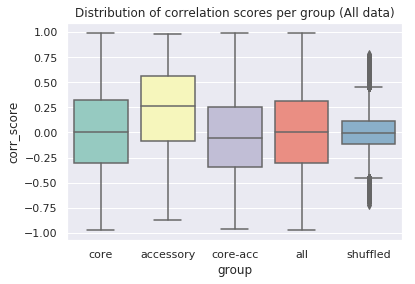

In [24]:
# Plot all correlation scores
sns.boxplot(data=corr_scores_df,
           x='group',
           y='corr_score',
           palette='Set3').set_title('Distribution of correlation scores per group ({} data)'.format(which_experiments))

/home/alexandra/anaconda3/envs/core-acc/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Correlation score')

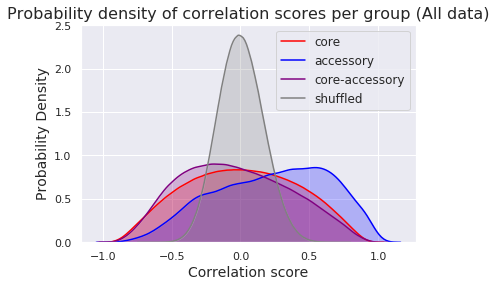

In [25]:
# Distribution plot for core genes
sns.distplot(real_core_corr_score, 
             label='core', 
             color='red',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )

sns.distplot(real_acc_corr_score,
             label='accessory',
             color='blue',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )
sns.distplot(real_core_acc_corr_score, 
             label='core-accessory', 
             color='purple',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )
sns.distplot(shuffled_all_corr_score,
             label='shuffled', 
             color='grey',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )

plt.legend(prop={'size': 12})
plt.title('Probability density of correlation scores per group ({} data)'.format(which_experiments), 
          fontsize=16)
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('Correlation score', fontsize=14)

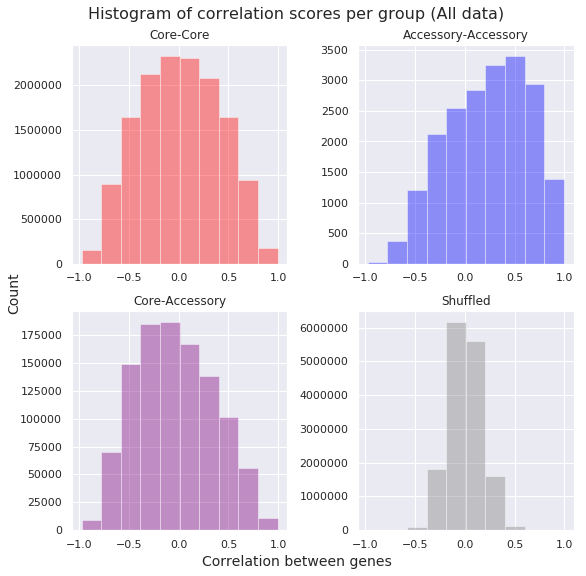

In [26]:
# Get bins using all data
hist, bins_corr = np.histogram(np.concatenate([real_core_corr_score,
                                              real_acc_corr_score,
                                              real_core_acc_corr_score,
                                              shuffled_all_corr_score]))

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

# Distribution plot for core genes
sns.distplot(real_core_corr_score, 
             label='core', 
             color='red',
             bins=bins_corr,
             kde=False,
             ax=axes[0,0]
            )

sns.distplot(real_acc_corr_score,
             label='accessory',
             color='blue',
             bins=bins_corr,
             kde=False,
             ax=axes[0,1]
            )
sns.distplot(real_core_acc_corr_score, 
             label='core-accessory', 
             color='purple',
             bins=bins_corr,
             kde=False,
             ax=axes[1,0]
            )
sns.distplot(shuffled_all_corr_score,
             label='shuffled', 
             color='grey',
             bins=bins_corr,
             kde=False,
             ax=axes[1,1]
            )

plt.suptitle('Histogram of correlation scores per group ({} data)'.format(which_experiments),
            fontsize=16)
axes[0,0].set_title('Core-Core')
axes[0,1].set_title('Accessory-Accessory')
axes[1,0].set_title('Core-Accessory')
axes[1,1].set_title('Shuffled')
fig.text(0.5, 0.01, 'Correlation between genes', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

**Note about visualizations:**
* Based on the density plot, we observed a shift in the accessory-accessory gene correlation scores. This density plot represents the probability of a random variable falling within a particular range of values (P(0 <= X <= 0.5)). This probability is given by the integral of this variable's PDF over that range -- that is it is given by the area under the density function. So there is a higher likelihood of correlation scores > 0.5 for accessory-accessory genes compared to core-core genes. But the *exact probability* of accessory-accessory genes having a correlation score > 0.5 is not known from just visually inspecting the density plot. To get the exact probability we would need to calculate the integral from 0.5 onward.
* While the shift if very clear to see in the density plot, the meaning of the y-axis is not as intuitive, so we also plot histograms for each group of genes. The histogram also shows a shift in the accessory-accessory gene correlation scores and also shows that the number of accessory-accessory interactions is orders of magnitude lower compared to core-core interactions.

https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

**Some sanity checks:**
* Shuffled dataset has very little correlation between genes, as expected since we have disrupted the inherent relationships between genes through our permutation process
* Since core genes comprise 97% of the total genes, the mean correlation for all genes is the same as the core gene set

**Overall observations:**
* Looking at the density plot for the accessory-accessory gene correlation scores, the scores are shifted to the right.
* The shift in acc-acc genes having higher correlation scores is more prominent in mixed sample datasets (`which_experiment == 'All'`). This shift is especially prominent in the PA14-only dataset (`which_experiment == 'PA14'`), where the accessory genes are absent.

## Examine expression of genes per group
**Question**
Is the reason for this shift because the accessory genes are absent? In other words, is the expression values for ALL accessory genes very low in across samples and so that is why they are all very correlated?

In [27]:
# Get mean, max, min expression per core gene
mean_real_core_expression = real_core_expression.mean()
max_real_core_expression = real_core_expression.max()
min_real_core_expression = real_core_expression.min()

In [28]:
# Get mean, max, min expression per accessory gene
mean_real_acc_expression = real_acc_expression.mean()
max_real_acc_expression = real_acc_expression.max()
min_real_acc_expression = real_acc_expression.min()

Text(0.5, 0, 'Mean gene expression')

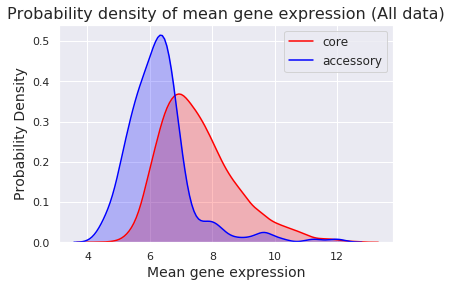

In [29]:
# Distribution plot for core genes
sns.distplot(mean_real_core_expression, 
             label='core', 
             color='red',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )

sns.distplot(mean_real_acc_expression,
             label='accessory',
             color='blue',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )

plt.legend(prop={'size': 12})
plt.title('Probability density of mean gene expression ({} data)'.format(which_experiments),
         fontsize=16)
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('Mean gene expression', fontsize=14)

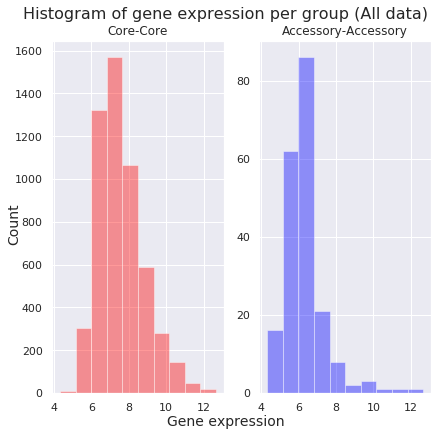

In [30]:
# Get bins using all data
hist, bins_expression = np.histogram(np.concatenate([mean_real_core_expression,
                                              mean_real_acc_expression]))


# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,6))

# Distribution plot for core genes
sns.distplot(mean_real_core_expression, 
             label='core', 
             color='red',
             bins=bins_expression,
             kde=False,
             ax=axes[0]
            )

sns.distplot(mean_real_acc_expression,
             label='accessory',
             color='blue',
             bins=bins_expression,
             kde=False,
             ax=axes[1]
            )

plt.suptitle('Histogram of gene expression per group ({} data)'.format(which_experiments),
            fontsize=16)
axes[0].set_title('Core-Core')
axes[1].set_title('Accessory-Accessory')
fig.text(0.5, 0.01, 'Gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

**Take away**:
* If high corr(acc, acc) was due to gene absence, then I would’ve expected the average expression of accessory genes to be tightly spread near 0. But instead we see that average gene expression of accessory genes is similar to the core gene expression, even using only PA14 strains
* What can explain this? 